In [2]:
# importing modules needed

import os
import pandas as pd
import numpy as np
from scipy import stats
import openpyxl
import matplotlib.pyplot as plt
import scipy
from scipy.fftpack import irfft, rfft

%matplotlib inline
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
import seaborn as sns

In [51]:
# folder path created for code and also the raw files
p1 = os.getcwd()
p2 = 'Final_Raw_Data'
path = os.path.join(p1,p2)

In [52]:
# here we set the type of conveyor only which we want to merge the data

lst = ["DEC_EDT","STR_EDT","INC_EDT","CUR_EDT"]


Data_final = pd.DataFrame()


# below loop will load excel files one by one
# load it into a dataframe and filter it on conveyor type
# append the filtered data to a new dataframe Data_final

for i in os.listdir(path):
    #if i[-24:] == '_TEST_LOOP_RAW_DATA.xlsx':
    #print(i)
    df = pd.read_excel(path+'\\'+i)
    #print(df.shape)
    #df2 =df[df['Defect_Introduced'].isin([CASE_1,CASE_2,CASE_3])]
    df2 =df[df.Sensor_Loc.isin(lst)]
    print(df2.shape)
    Data_final = Data_final.append(df2)

(153, 4103)
(158, 4103)
(138, 4103)
(0, 4103)
(0, 4103)
(0, 4103)
(0, 4103)
(148, 4103)
(482, 4103)
(0, 4103)
(0, 4103)
(0, 4103)
(0, 4103)
(0, 4103)
(0, 4103)
(108, 4103)
(141, 4103)
(0, 4103)
(0, 4103)
(57, 4103)
(195, 4103)
(0, 4103)


In [53]:
Data_final.to_excel('Others-EDT-RawData-except-MET.xlsx')

In [3]:
## data will be directly imported from the saved excel file

Data_final = pd.read_excel('Others-EDT-RawData-except-MET.xlsx')

In [5]:
Data_final.head()

,Unnamed: 0,index,Data_pull_time,Mac_Id,Axis,Defect_Introduced,Asset_Id,Sensor_Loc,Vsample1,Vsample2,...,Vsample4087,Vsample4088,Vsample4089,Vsample4090,Vsample4091,Vsample4092,Vsample4093,Vsample4094,Vsample4095,Vsample4096
0,0,0,2020-08-04 08:57:34,29:9c:fe:16,X,Faulty damper bush introduced- with no tray,101.CA.DTL.01.1-060,CUR_EDT,-0.171875,-0.140625,...,0.218750,0.328125,0.375000,0.296875,0.171875,-0.046875,-0.265625,-0.43750,-0.546875,-0.562500
1,1,1,2020-08-04 09:26:50,29:9c:fe:16,X,Faulty damper bush introduced- with no tray,101.CA.DTL.01.1-060,CUR_EDT,-0.171875,0.234375,...,-0.015625,0.203125,0.265625,0.281250,0.265625,0.140625,0.015625,-0.03125,-0.015625,0.046875
2,2,2,2020-08-04 10:01:31,29:9c:fe:16,X,Faulty damper bush introduced- with no tray,101.CA.DTL.01.1-060,CUR_EDT,-0.171875,-0.140625,...,-0.281250,-0.265625,-0.109375,0.015625,0.140625,0.093750,-0.046875,-0.21875,-0.375000,-0.421875
3,3,3,2020-08-04 10:22:34,29:9c:fe:16,X,Faulty damper bush introduced- with no tray,101.CA.DTL.01.1-060,CUR_EDT,0.171875,-0.109375,...,0.046875,-0.140625,-0.359375,-0.515625,-0.453125,-0.343750,-0.187500,0.00000,0.156250,0.218750
4,4,4,2020-08-04 08:58:17,29:9c:fe:16,Y,Faulty damper bush introduced- with no tray,101.CA.DTL.01.1-060,CUR_EDT,-0.171875,-0.640625,...,-0.046875,-0.203125,-0.531250,-0.921875,-1.296875,-1.531250,-1.562500,-1.37500,-1.140625,-0.656250


In [6]:
Data_final.head()
Data_final.drop('Unnamed: 0',axis=1,inplace=True)

In [7]:
Data = Data_final.copy()

In [8]:
Data_Processed = pd.DataFrame()
sec = 1.2792877225866917
secs = 1.2792877225866917
N = 4096
fs_rate=round(N/sec)
fs_rate
Ts = 1.0/fs_rate # sampling interval in time
t = np.arange(0, secs, Ts) # time vector as scipy arange field / numpy.ndarray
freqs = scipy.fftpack.fftfreq(N, t[1]-t[0])
freqs_side = freqs[range(N//2)] # one side frequency range
## high pass filter
for i,row in Data.iterrows():
    data = row['Vsample1':'Vsample4096'] - row['Vsample1':'Vsample4096'].mean() # subracting mean from the samples
    #print(row["Data_pull_time":"Sensor_Loc"])
    f_signal = rfft(data)
    #print(row['Vsample1':'Vsample6'])
    #print(f_signal[:5])
    #print(len(f_signal))
    #If our original signal time was in seconds, this is now in Hz    
    cut_f_signal = f_signal.copy()
    #cut_f_signal[(freqs<6) & (freqs>-6)] = 0
    data = irfft(cut_f_signal)
    rms = np.sqrt(np.mean(np.array(data)**2))
    kurt=stats.kurtosis(data)
    if rms>.02 and kurt<300 and freqs_side[-1]>1550: ## to keep the range at least 800 hz
        FFT = scipy.fft.fft(data)
        FFT_side = FFT[range(N//2)] # one side FFT range, because we need just the haf of the frequency data because of symmetry
        abs_fft_1=abs(FFT_side)
        
        payload={
                        "Data_pull_time" : row["Data_pull_time"],
                        "Mac_Id" : row["Mac_Id"],
                        "Axis" : row["Axis"],
                        "Defect_Introduced" : row["Defect_Introduced"],
                        "Asset_Id" : row["Asset_Id"],
                        "Sensor_Loc":row["Sensor_Loc"],
                        "peak-peak": (max(data)-min(data)),
                        "rms": rms,
                        "kurt":kurt,
                        "crest":np.max(np.abs(data))/np.sqrt(np.mean(np.square(data))),
                        "variance":np.var(data),
                        "mean":np.mean(data),
                        "skewness":stats.skew(data),
                        'freqAmpliMean':np.mean(abs_fft_1),
                        'freqAmpliMax':max(abs_fft_1),
                        'freqAmpliKurt':stats.kurtosis(abs_fft_1),
                        'freqAmpliskw':stats.skew(abs_fft_1),
                        'freqAmpliVar':np.var(abs_fft_1),
                        }
        lenFreq=len(freqs_side)
        lastFreq=freqs_side[-1]
        abs_fft_1=list(abs_fft_1)
        jj=0
        feqv=1
        while jj < lenFreq and feqv<=8: ## for 8 bins from 0 to 1600 Hz
            #print('Condition satisfied')
            kk=int(round(jj+lenFreq/lastFreq*200)) ## 100 is freqency step size for binnning
            #print(kk)
            fft_Range=abs_fft_1[jj:kk]
            freq_sideRange=freqs_side[jj:kk]
            jj=kk
            payload['max_{}'.format(feqv)]=max(fft_Range)
            payload['mean_{}'.format(feqv)]=np.mean(fft_Range)
            payload['var_{}'.format(feqv)]=np.var(fft_Range)
            feqv+=1
        Data_Processed = Data_Processed.append(payload, ignore_index=True)


In [7]:
Data_Processed.Defect_Introduced.value_counts()

No Defect_Empty Tray                                                                                                  289
No Defect_with no tray                                                                                                156
Faulty damper bush introduced- with no tray                                                                           149
Faulty damper bush introduced & Wobling drive introduced- with no tray                                                135
non drive side faulty bearing was introduced_with no tray                                                             132
No Defect_No Load                                                                                                     122
Drive shaft bearing faulty and Drive pulley faulty Introduced_with no tray                                            102
Drive shaft bearing faulty and Drive pulley faulty Introduced & Wobling drive motor faulty introduced_with no tray     88
Decline-Non Drive Side T

### Metering EDT :  fault names grouped, also load and no load

Importance of components:


,sdev,varprop,cumprop
,Standard deviation,Proportion of Variance,Cumulative Proportion
PC1,3.515681e+00,3.433338e-01,0.343334
PC2,3.046915e+00,2.578803e-01,0.601214
PC3,2.045980e+00,1.162787e-01,0.717493
PC4,1.726619e+00,8.281149e-02,0.800304
PC5,1.248470e+00,4.329657e-02,0.843601
PC6,1.124829e+00,3.514554e-02,0.878746
PC7,9.422969e-01,2.466454e-02,0.903411
PC8,8.844989e-01,2.173162e-02,0.925143
PC9,7.508926e-01,1.566221e-02,0.940805


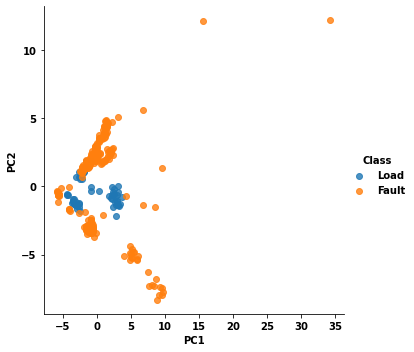

In [48]:
Load_NoLoad_group = {"No Defect_No Load": "No_Load",
                     "No Defect_Empty Tray":"Load",
                     "No Defect_with no tray" : "No_Load",
                    "slight wobbling in the motor_No Load": "Fault",
                    "slight wobbling in the motor_Empty Tray":"Fault",
                    "Drive side belt removed_with no tray":"Fault",
                    "non drive side faulty bearing was introduced_with no tray":"Fault",
                    "Decline-Non Drive Side Tesnion unit faulty bearing & Drive side belt removed- with no Tray":"Fault",
                    "Non Drive side faulty bearing was introduced - with no tray":"Fault",
                    "Belt showing signs of wear and tear, slight wobbling in the motor":"Fault"}

Data_Processed["Actual_Cluster"] = [ Load_NoLoad_group[i] for i in Data_Processed.Defect_Introduced]

Data_rearrange = Data_Processed[['Asset_Id', 'Axis', 'Data_pull_time', 'Defect_Introduced', 'Mac_Id',
       'Sensor_Loc','Actual_Cluster', 'crest', 'freqAmpliKurt', 'freqAmpliMax', 'freqAmpliMean',
       'freqAmpliVar', 'freqAmpliskw', 'kurt', 'max_1', 'max_2', 'max_3',
       'max_4', 'max_5', 'max_6', 'max_7', 'max_8', 'mean', 'mean_1', 'mean_2',
       'mean_3', 'mean_4', 'mean_5', 'mean_6', 'mean_7', 'mean_8', 'peak-peak',
       'rms', 'skewness', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6',
       'var_7', 'var_8', 'variance']]

#Data_rearrange.columns

Data_rearrange = Data_rearrange[(Data_rearrange.Actual_Cluster!= 'No_Load') &  (Data_rearrange.Axis =='Z')]

X = Data_rearrange.loc[:,"crest":]  # independent variables data
y = Data_rearrange.Actual_Cluster  # dependednt variable data


standardisedX = scale(X)
standardisedX = pd.DataFrame(standardisedX, index=X.index, columns=X.columns)

standardisedX.apply(np.mean)
standardisedX.apply(np.std)

pca = PCA().fit(standardisedX)

def pca_summary(pca, standardised_data, out=True):
    names = ["PC"+str(i) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    a = list(np.std(pca.transform(standardised_data), axis=0))
    b = list(pca.explained_variance_ratio_)
    c = [np.sum(pca.explained_variance_ratio_[:i]) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    columns = pd.MultiIndex.from_tuples([("sdev", "Standard deviation"), ("varprop", "Proportion of Variance"), ("cumprop", "Cumulative Proportion")])
    summary = pd.DataFrame(zip(a, b, c), index=names, columns=columns)
    if out:
        print("Importance of components:")
        display(summary)
    return summary

summary = pca_summary(pca, standardisedX)
#summary.sdev**2

def pca_scatter(pca, standardised_values, classifs):
    foo = pca.transform(standardised_values)
    bar = pd.DataFrame(zip(foo[:, 0], foo[:, 1], classifs), columns=["PC1", "PC2", "Class"])
    sns.lmplot("PC1", "PC2", bar, hue="Class", fit_reg=False)

pca_scatter(pca, standardisedX, y)



### for EDT location other than metering

In [25]:
Data_Processed.Sensor_Loc.value_counts()


CUR_EDT    866
DEC_EDT    249
STR_EDT    222
INC_EDT    132
Name: Sensor_Loc, dtype: int64

Importance of components:
        PC1       PC2  Class
0 -1.440765  4.928280  Fault
1 -2.265389  1.254586  Fault
2 -1.368898  2.972407  Fault
3 -0.828734  4.211228  Fault
4 -2.725209  2.018973  Fault


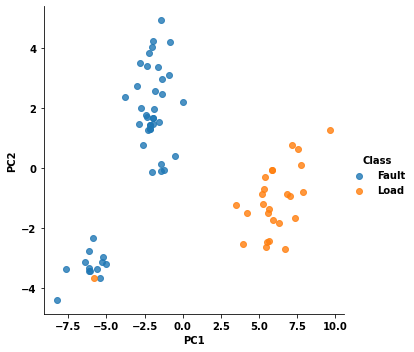

In [15]:
Load_NoLoad_group = {"No Defect_No Load": "No_Load",
                     "No Defect_Empty Tray":"Load",
                     "No Defect_with no tray" : "No_Load",
                     "Faulty damper bush introduced- with no tray":"Fault",
                     "Faulty damper bush introduced & Wobling drive introduced- with no tray":"Fault",
                     "Drive shaft bearing faulty and Drive pulley faulty Introduced_with no tray":"Fault",
                     "Drive shaft bearing faulty and Drive pulley faulty Introduced & Wobling drive motor faulty introduced_with no tray":"Fault",
                     "Decline-Non Drive Side Tesnion unit faulty bearing & Drive side belt removed- with no Tray":"Fault",
                     "Decline-Non Drive Side Tesnion unit faulty bearing- with no Tray":"Fault",
                    "slight wobbling in the motor_No Load": "Fault",
                    "slight wobbling in the motor_Empty Tray":"Fault",
                    "Drive side belt removed_with no tray":"Fault",
                    "non drive side faulty bearing indtroduced_with no tray":"Fault",
                    "non drive side faulty bearing introduced & Drive side belt removed_with no tray":"Fault",
                    "non drive side faulty bearing indtroduced & Drive side belt removed_with no tray":"Fault",
                    "non drive side faulty bearing was introduced_with no tray":"Fault"}

Data_Processed["Actual_Cluster"] = [ Load_NoLoad_group[i] for i in Data_Processed.Defect_Introduced]

Data_rearrange = Data_Processed[['Asset_Id', 'Axis', 'Data_pull_time', 'Defect_Introduced', 'Mac_Id',
       'Sensor_Loc','Actual_Cluster', 'crest', 'freqAmpliKurt', 'freqAmpliMax', 'freqAmpliMean',
       'freqAmpliVar', 'freqAmpliskw', 'kurt', 'max_1', 'max_2', 'max_3',
       'max_4', 'max_5', 'max_6', 'max_7', 'max_8', 'mean', 'mean_1', 'mean_2',
       'mean_3', 'mean_4', 'mean_5', 'mean_6', 'mean_7', 'mean_8', 'peak-peak',
       'rms', 'skewness', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6',
       'var_7', 'var_8', 'variance']]

#Data_rearrange.columns

#Data_rearrange = Data_rearrange[(Data_rearrange.Actual_Cluster!= 'No_Load') &  (Data_rearrange.Axis =='Z')]
Data_rearrange = Data_rearrange[(Data_rearrange.Sensor_Loc == 'DEC_EDT') &  (Data_rearrange.Axis =='Y') & (Data_rearrange.Actual_Cluster!= 'No_Load')]
#Data_rearrange = Data_rearrange[Data_rearrange.Axis =='Z']

X = Data_rearrange.loc[:,"crest":]  # independent variables data
y = Data_rearrange.Actual_Cluster  # dependednt variable data


standardisedX = scale(X)
standardisedX = pd.DataFrame(standardisedX, index=X.index, columns=X.columns)

standardisedX.apply(np.mean)
standardisedX.apply(np.std)

pca = PCA().fit(standardisedX)

def pca_summary(pca, standardised_data, out=True):
    names = ["PC"+str(i) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    a = list(np.std(pca.transform(standardised_data), axis=0))
    b = list(pca.explained_variance_ratio_)
    c = [np.sum(pca.explained_variance_ratio_[:i]) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    columns = pd.MultiIndex.from_tuples([("sdev", "Standard deviation"), ("varprop", "Proportion of Variance"), ("cumprop", "Cumulative Proportion")])
    summary = pd.DataFrame(zip(a, b, c), index=names, columns=columns)
    if out:
        print("Importance of components:")
        #display(summary)
    return summary

summary = pca_summary(pca, standardisedX)
#summary.sdev**2

def pca_scatter(pca, standardised_values, classifs):
    foo = pca.transform(standardised_values)
    bar = pd.DataFrame(zip(foo[:, 0], foo[:, 1], classifs), columns=["PC1", "PC2", "Class"])
    #bar = bar[bar.PC1 < 2.5]
    print(bar.head())
    sns.lmplot("PC1", "PC2", bar, hue="Class", fit_reg=False)

pca_scatter(pca, standardisedX, y)



In [105]:
Case1 = "No Defect_No Load"
Case2 = "No Defect_with no tray"


Load_Vs_Fault =Data[~Data.Defect_Introduced.isin([Case1,Case2])]

In [106]:
Load_Vs_Fault.head()

,Data_pull_time,Mac_Id,Axis,Defect_Introduced,Asset_Id,Sensor_Loc,Vsample1,Vsample2,Vsample3,Vsample4,...,Vsample4087,Vsample4088,Vsample4089,Vsample4090,Vsample4091,Vsample4092,Vsample4093,Vsample4094,Vsample4095,Vsample4096
259,2020-07-21 12:37:43,29:9c:fe:16,X,No Defect_Empty Tray,101.CA.DTL.01.1-050,MET_EDT,0.171875,-0.046875,-0.031250,-0.015625,...,-0.296875,0.062500,0.328125,0.281250,0.000000,-0.031250,0.062500,-0.156250,-0.250000,-0.125000
260,2020-07-21 13:32:32,29:9c:fe:16,X,No Defect_Empty Tray,101.CA.DTL.01.1-050,MET_EDT,0.171875,0.265625,0.140625,0.078125,...,0.500000,0.406250,0.437500,0.281250,0.046875,-0.046875,-0.203125,-0.265625,-0.250000,-0.234375
261,2020-07-21 13:49:25,29:9c:fe:16,X,No Defect_Empty Tray,101.CA.DTL.01.1-050,MET_EDT,0.171875,-0.296875,0.031250,0.421875,...,-0.187500,-0.031250,-0.062500,-0.046875,0.109375,0.359375,0.390625,-0.078125,-0.140625,-0.296875
262,2020-07-21 14:15:48,29:9c:fe:16,X,No Defect_Empty Tray,101.CA.DTL.01.1-050,MET_EDT,0.171875,-0.171875,0.031250,0.062500,...,-0.343750,-0.281250,-0.218750,-0.171875,-0.046875,0.000000,0.015625,-0.093750,-0.250000,-0.125000
263,2020-07-21 15:06:27,29:9c:fe:16,X,No Defect_Empty Tray,101.CA.DTL.01.1-050,MET_EDT,0.171875,0.140625,0.015625,-0.093750,...,0.031250,0.078125,-0.093750,-0.250000,-0.265625,-0.250000,-0.140625,-0.015625,0.234375,0.265625


In [ ]:
#row = Data_final.iloc[228]['Vsample1':'Vsample4096']
N=4096
sec = 1.279374957
fs_rate=round(N/sec) ## alternatively that means frequency

   
secs = N / float(fs_rate) ## time for which it will be played in sec

Ts = 1.0/fs_rate # sampling interval in time

t = np.arange(0, secs, Ts) # time vector as scipy arange field / numpy.ndarray

freqs = scipy.fft.fftfreq(N, t[1]-t[0])
#print(freqs[4095])
freqs_side = freqs[range(N//2)] # one side frequency range

for j in ['X','Y','Z']:
    print(j)
    for i,row in Load_Vs_Fault[Load_Vs_Fault.Axis == j].iterrows():
    #if (row['Vsample1':'Vsample4096'].max() > 2) and (row['Vsample1':'Vsample4096'].min() < 0) :
        data = row['Vsample1':'Vsample4096']
        fig, axs = plt.subplots(2)
        axs[0].plot(data)
        axs[0].set_ylim(-4,4)
        fig.suptitle(str(row['Data_pull_time']) +'\n'+row['Defect_Introduced']+'\n'+row['Sensor_Loc'])
        #fig.title(str(row['Data_pull_time'])+' '+row['Axis'])
        
        FFT = scipy.fft.fft(data)
        axs[1].plot(freqs,FFT)
        fig.savefig('./Load_Vs_Fault/'+j+'/'+row['Mac_Id'].replace(":","")+'_'+row['Axis']+'_'+str(i)+'.png',dpi=400)
        #fig.savefig('test.png')
        plt.close()

X


C:\Users\husssabe\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\husssabe\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\husssabe\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\husssabe\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\husssabe\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning:

C:\Users\husssabe\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\husssabe\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\husssabe\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\husssabe\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\husssabe\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning:

C:\Users\husssabe\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\husssabe\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\husssabe\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\husssabe\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\husssabe\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning:

In [18]:
Data_Defect_names = Data_Processed[Data_Processed.Axis == 'X']


In [20]:
Data_Defect_names.head()
X = Data_Defect_names.loc[:,"crest":"variance"]
y = Data_Defect_names.Defect_Introduced

In [21]:
#Mean and Std deviation by Gp
def printMeanAndSdByGroup(variables, groupvariable):
    data_groupby = variables.groupby(groupvariable)
    print("## Means:")
    display(data_groupby.apply(np.mean))
    print("\n## Standard deviations:")
    display(data_groupby.apply(np.std))
    print("\n## Sample sizes:")
    display(pd.DataFrame(data_groupby.apply(len)))

printMeanAndSdByGroup(X, y)

## Means:


,crest,freqAmpliKurt,freqAmpliMax,freqAmpliMean,freqAmpliVar,freqAmpliskw,kurt,max_1,max_2,max_3,...,skewness,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,variance
Defect_Introduced,,,,,,,,,,,,,,,,,,,,,
"Belt showing signs of wear and tear, slight wobbling in the motor",5.449417,170.969186,166.239930,5.656079,54.777632,9.120268,11.637495,165.783309,64.631835,12.243152,...,-0.012563,222.188758,79.536290,5.902380,20.158926,7.088689,12.621182,7.934900,10.032443,0.022926
Decline-Non Drive Side Tesnion unit faulty bearing & Drive side belt removed- with no Tray,3.790546,281.637861,428.662771,9.990191,245.664549,12.080987,0.144869,428.662771,104.288412,24.763181,...,0.051208,1177.540526,266.112782,17.044615,27.608415,29.412796,8.282798,5.950858,2.293871,0.084530
Drive side belt removed_with no tray,8.932505,17.114276,167.742984,9.468463,426.259943,3.328218,8.472796,89.285089,158.610237,68.986830,...,-0.076432,257.010401,1472.068854,237.198069,11.000380,3.968145,2.762500,1.687676,1.617247,0.136833
No Defect_Empty Tray,6.532250,35.128868,148.838222,7.072651,133.260072,4.435764,3.900191,129.740247,76.741053,43.646450,...,0.013375,328.594322,175.750971,88.516344,25.194478,2.787034,1.114476,0.902499,0.823254,0.046493
No Defect_No Load,5.217988,113.765641,163.372639,4.768021,93.958033,7.396707,4.754161,163.163728,53.329441,13.872157,...,-0.096052,485.284381,66.433511,8.604231,11.142928,2.735309,1.606016,1.090484,0.667025,0.030718
No Defect_with no tray,5.401324,37.423549,285.036629,13.254315,605.009480,4.458885,4.113364,150.086468,245.792579,117.055149,...,-0.142276,516.203602,1943.377225,506.566199,12.162528,4.455038,3.868828,2.585152,1.787045,0.193979
Non Drive side faulty bearing was introduced - with no tray,4.313990,33.867644,195.020450,7.752636,311.418494,4.797969,0.982188,192.565591,88.496439,26.197365,...,0.005809,1186.923174,229.203034,23.480741,1.713594,0.827793,0.409646,0.300444,0.249812,0.091455
non drive side faulty bearing was introduced_with no tray,4.635507,30.868918,122.769681,8.068206,100.755728,4.232837,5.042687,67.119070,116.186151,18.164912,...,0.106445,125.736133,310.036897,11.266312,24.652901,12.733894,15.877712,2.595725,2.026082,0.041563
slight wobbling in the motor_Empty Tray,5.821529,94.408809,186.202055,6.933269,92.239230,6.834222,1.616109,186.202055,91.489692,19.101285,...,-0.023482,312.058832,184.550889,10.321820,15.683929,4.785470,4.586385,4.403138,6.481715,0.034710



## Standard deviations:


,crest,freqAmpliKurt,freqAmpliMax,freqAmpliMean,freqAmpliVar,freqAmpliskw,kurt,max_1,max_2,max_3,...,skewness,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,variance
Defect_Introduced,,,,,,,,,,,,,,,,,,,,,
"Belt showing signs of wear and tear, slight wobbling in the motor",4.549615,86.221887,53.216178,2.670598,21.371259,2.933990,43.543275,54.231831,18.250946,3.798654,...,0.063714,74.887286,22.904317,5.508034,6.403174,14.465404,40.537267,21.398654,23.500718,0.017558
Decline-Non Drive Side Tesnion unit faulty bearing & Drive side belt removed- with no Tray,0.877444,90.384360,51.540373,0.874505,19.770666,2.261785,1.467524,51.540373,16.031536,3.591287,...,0.052791,140.015028,43.337512,4.769659,10.710248,11.718450,5.223619,2.021994,0.662538,0.008259
Drive side belt removed_with no tray,5.291261,9.165566,141.689328,6.675058,467.280088,1.060462,11.674560,60.765699,144.378281,56.618772,...,0.999268,211.975926,1824.539439,262.958597,22.043555,8.638262,6.044321,2.577888,2.714092,0.144559
No Defect_Empty Tray,2.134329,23.007208,80.011753,2.674243,89.998246,1.029105,5.972938,83.660593,50.836733,34.698171,...,0.145931,299.138630,226.358969,99.151219,36.576776,3.525982,0.758378,0.509172,0.647643,0.030120
No Defect_No Load,3.088547,130.639393,171.434804,3.020975,206.250572,3.755032,24.099937,171.565083,19.960282,8.873998,...,0.811915,1264.440120,58.807817,21.393307,14.075572,4.904949,3.313155,2.070136,1.251048,0.065495
No Defect_with no tray,2.616117,66.222842,137.737232,3.721618,339.635404,2.286874,10.501209,140.571472,102.206838,57.154381,...,0.705837,775.553885,1424.331705,447.971885,21.784371,9.790655,9.745737,5.328777,2.176706,0.106128
Non Drive side faulty bearing was introduced - with no tray,1.295055,30.480458,47.692337,1.753948,121.669736,1.240839,5.180849,48.219608,38.615331,9.572249,...,0.085257,487.678592,229.642985,22.493967,5.759106,4.578008,1.185208,0.366187,0.113644,0.035877
non drive side faulty bearing was introduced_with no tray,2.704518,20.281500,40.670871,2.094736,70.339833,0.992554,29.589152,38.929231,30.878288,4.146121,...,0.806782,135.377572,67.682287,6.500453,5.453421,5.873465,7.433689,4.207144,4.798798,0.031856
slight wobbling in the motor_Empty Tray,1.430488,51.105787,43.803034,1.362093,26.202755,1.547111,1.148759,43.803034,29.421841,3.855644,...,0.132064,85.555976,74.252155,2.724959,4.605705,1.277576,1.458587,1.501718,2.579875,0.009177



## Sample sizes:


,0
Defect_Introduced,
"Belt showing signs of wear and tear, slight wobbling in the motor",18
Decline-Non Drive Side Tesnion unit faulty bearing & Drive side belt removed- with no Tray,57
Drive side belt removed_with no tray,41
No Defect_Empty Tray,70
No Defect_No Load,117
No Defect_with no tray,37
Non Drive side faulty bearing was introduced - with no tray,85
non drive side faulty bearing was introduced_with no tray,53
slight wobbling in the motor_Empty Tray,22


### Standardisation

In [22]:
standardisedX = scale(X)
standardisedX = pd.DataFrame(standardisedX, index=X.index, columns=X.columns)

standardisedX.apply(np.mean)
standardisedX.apply(np.std)

crest            1.0
freqAmpliKurt    1.0
freqAmpliMax     1.0
freqAmpliMean    1.0
freqAmpliVar     1.0
freqAmpliskw     1.0
kurt             1.0
max_1            1.0
max_2            1.0
max_3            1.0
max_4            1.0
max_5            1.0
max_6            1.0
max_7            1.0
max_8            1.0
mean             1.0
mean_1           1.0
mean_2           1.0
mean_3           1.0
mean_4           1.0
mean_5           1.0
mean_6           1.0
mean_7           1.0
mean_8           1.0
peak-peak        1.0
rms              1.0
skewness         1.0
var_1            1.0
var_2            1.0
var_3            1.0
var_4            1.0
var_5            1.0
var_6            1.0
var_7            1.0
var_8            1.0
variance         1.0
dtype: float64

### PCA

In [23]:
pca = PCA().fit(standardisedX)

In [24]:

def pca_summary(pca, standardised_data, out=True):
    names = ["PC"+str(i) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    a = list(np.std(pca.transform(standardised_data), axis=0))
    b = list(pca.explained_variance_ratio_)
    c = [np.sum(pca.explained_variance_ratio_[:i]) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    columns = pd.MultiIndex.from_tuples([("sdev", "Standard deviation"), ("varprop", "Proportion of Variance"), ("cumprop", "Cumulative Proportion")])
    summary = pd.DataFrame(zip(a, b, c), index=names, columns=columns)
    if out:
        print("Importance of components:")
        display(summary)
    return summary

In [25]:
summary = pca_summary(pca, standardisedX)

Importance of components:


,sdev,varprop,cumprop
,Standard deviation,Proportion of Variance,Cumulative Proportion
PC1,3.639742e+00,3.679923e-01,0.367992
PC2,2.828460e+00,2.222273e-01,0.590220
PC3,2.052242e+00,1.169916e-01,0.707211
PC4,1.669491e+00,7.742221e-02,0.784633
PC5,1.240894e+00,4.277274e-02,0.827406
PC6,1.130648e+00,3.551015e-02,0.862916
PC7,1.055174e+00,3.092753e-02,0.893844
PC8,9.767245e-01,2.649974e-02,0.920344
PC9,7.901892e-01,1.734442e-02,0.937688


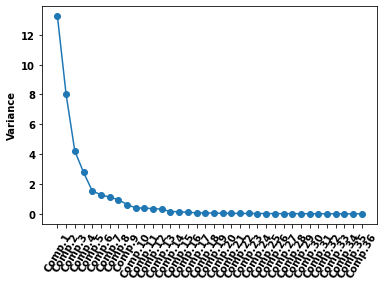

In [26]:
def screeplot(pca, standardised_values):
    y = np.std(pca.transform(standardised_values), axis=0)**2
    x = np.arange(len(y)) + 1
    plt.plot(x, y, "o-")
    plt.xticks(x, ["Comp."+str(i) for i in x], rotation=60)
    plt.ylabel("Variance")
    plt.show()

screeplot(pca, standardisedX)

In [79]:
# Using Kaiser’s criterion: that we should only retain principal components for which the variance is above 1
summary.sdev**2

,Standard deviation
PC1,1.403830e+01
PC2,6.297257e+00
PC3,4.081776e+00
PC4,2.571589e+00
PC5,1.575879e+00
PC6,1.336304e+00
PC7,9.986512e-01
PC8,9.926751e-01
PC9,7.326642e-01
PC10,6.672744e-01


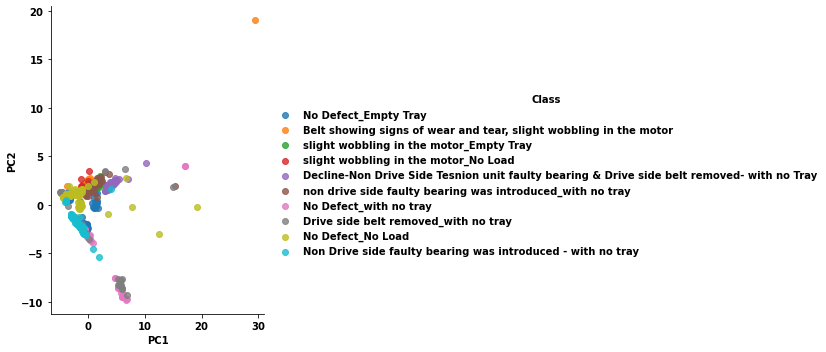

In [27]:
def pca_scatter(pca, standardised_values, classifs):
    foo = pca.transform(standardised_values)
    bar = pd.DataFrame(zip(foo[:, 0], foo[:, 1], classifs), columns=["PC1", "PC2", "Class"])
    sns.lmplot("PC1", "PC2", bar, hue="Class", fit_reg=False)

pca_scatter(pca, standardisedX, y)

# FEATURE SELECTION

### 1.  Feature Importance

In [111]:
X.head()

,crest,freqAmpliKurt,freqAmpliMax,freqAmpliMean,freqAmpliVar,freqAmpliskw,kurt,max_1,max_2,max_3,...,skewness,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,variance
0,17.692794,13.104953,102.389972,10.499526,112.147188,2.679013,47.478251,102.389972,58.281134,40.496273,...,0.260243,295.258373,117.998580,64.943508,82.691562,16.019398,3.086827,2.870635,2.164639,0.054294
1,6.550334,36.088744,125.279978,7.632612,97.949008,4.600817,2.020770,93.897703,123.016512,36.192456,...,0.013241,143.568690,255.952350,35.103860,89.907245,6.066775,2.207291,1.616244,1.162250,0.038136
2,5.147500,90.016390,214.603791,7.944266,107.284440,6.468396,1.162240,83.804118,214.603791,33.967946,...,-0.015044,128.992456,331.357015,41.748621,91.429373,6.852491,1.881266,1.169459,2.149036,0.041601
3,6.142973,38.604170,188.883617,10.130518,211.588810,4.846670,1.260115,86.962161,188.883617,41.706446,...,-0.114612,185.879459,779.423070,58.322527,69.898047,7.679959,2.025342,1.674472,1.387360,0.076713
4,4.920943,30.354636,182.508059,10.076308,202.985096,4.398374,1.124420,97.989781,182.508059,34.923259,...,0.054166,199.587168,700.936131,42.589595,55.949301,9.088518,1.836583,0.931422,1.177692,0.074345


In [112]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt



X = Data_rearrange.loc[:,"crest":]  # independent variables data
y = Data_rearrange.Actual_Cluster  # dependednt variable data



In [113]:

model = ExtraTreesClassifier()
model.fit(X,y)

ExtraTreesClassifier()

In [114]:
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

[0.04907665 0.0133481  0.02489573 0.02893617 0.03387278 0.01398685
 0.01939344 0.02539362 0.02269796 0.04341831 0.02048352 0.03143266
 0.03379268 0.01829588 0.02887397 0.         0.02908158 0.04383944
 0.04241083 0.03051471 0.03254514 0.0437807  0.02108242 0.02572867
 0.0209841  0.04155047 0.00984289 0.02988602 0.0402944  0.04409836
 0.01953626 0.02832645 0.03094249 0.01429021 0.0177531  0.02561344]


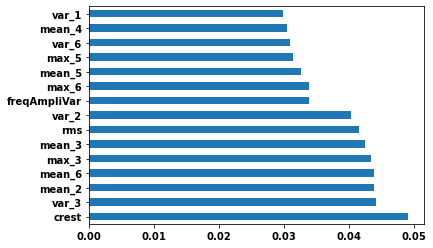

In [116]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

### 2. Correlation Matrix with Heatmap

In [41]:
Data_rearrange.Actual_Cluster.value_counts()

Series([], Name: Actual_Cluster, dtype: int64)

In [131]:
Load_NoLoad_num = {"Fault": 2,
                     "Load":1}

Data_rearrange["Load_Fault"] = [ Load_NoLoad_num[i] for i in Data_rearrange.Actual_Cluster]

In [40]:
Data_rearrange.head()

,Asset_Id,Axis,Data_pull_time,Defect_Introduced,Mac_Id,Sensor_Loc,Actual_Cluster,crest,freqAmpliKurt,freqAmpliMax,...,skewness,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,variance


In [39]:
Data_rearrange = Data_rearrange[Data_rearrange.Axis == 'Z']

C:\Users\husssabe\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\husssabe\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\matrix.py:208: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


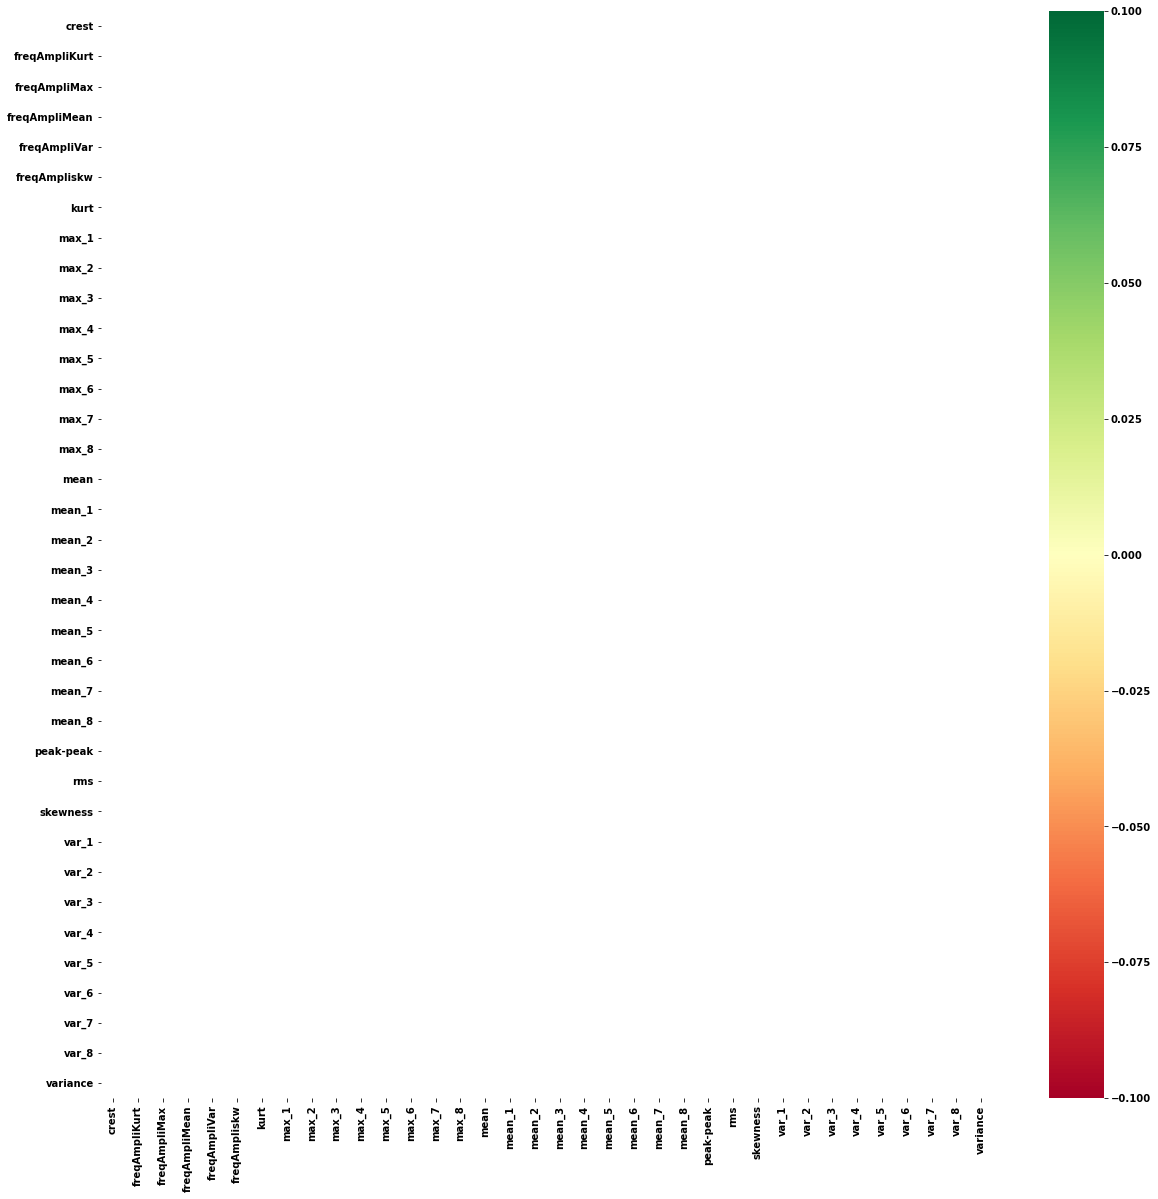

In [37]:
import seaborn as sns
#get correlations of each features in dataset
corrmat = Data_rearrange.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(Data_rearrange[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### Recursive-Feature-Elimination

In [43]:
Data_RFE = Data_Processed.copy()

In [44]:
Load_NoLoad_group = {"No Defect_No Load": "No_Load",
                     "No Defect_Empty Tray":"Load",
                     "No Defect_with no tray" : "No_Load",
                     "Faulty damper bush introduced- with no tray":"Fault",
                     "Faulty damper bush introduced & Wobling drive introduced- with no tray":"Fault",
                     "Drive shaft bearing faulty and Drive pulley faulty Introduced_with no tray":"Fault",
                     "Drive shaft bearing faulty and Drive pulley faulty Introduced & Wobling drive motor faulty introduced_with no tray":"Fault",
                     "Decline-Non Drive Side Tesnion unit faulty bearing & Drive side belt removed- with no Tray":"Fault",
                     "Decline-Non Drive Side Tesnion unit faulty bearing- with no Tray":"Fault",
                    "slight wobbling in the motor_No Load": "Fault",
                    "slight wobbling in the motor_Empty Tray":"Fault",
                    "Drive side belt removed_with no tray":"Fault",
                    "non drive side faulty bearing indtroduced_with no tray":"Fault",
                    "non drive side faulty bearing introduced & Drive side belt removed_with no tray":"Fault",
                    "non drive side faulty bearing indtroduced & Drive side belt removed_with no tray":"Fault",
                    "non drive side faulty bearing was introduced_with no tray":"Fault"}

Data_RFE["Actual_Cluster"] = [ Load_NoLoad_group[i] for i in Data_RFE.Defect_Introduced]

In [45]:
Data_RFE.head()

,Asset_Id,Axis,Data_pull_time,Defect_Introduced,Mac_Id,Sensor_Loc,crest,freqAmpliKurt,freqAmpliMax,freqAmpliMean,...,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,variance,Actual_Cluster
0,101.CA.DTL.01.1-060,X,2020-08-04 08:57:34,Faulty damper bush introduced- with no tray,29:9c:fe:16,CUR_EDT,3.543780,51.511987,156.035555,5.062589,...,266.720698,478.085919,2.690142,0.417431,0.361257,0.707333,0.233728,0.322860,0.039253,Fault
1,101.CA.DTL.01.1-060,X,2020-08-04 09:26:50,Faulty damper bush introduced- with no tray,29:9c:fe:16,CUR_EDT,2.963913,104.266846,235.973371,5.015261,...,230.540842,636.593896,3.249019,0.398956,0.397157,0.615014,0.362822,0.326555,0.042364,Fault
2,101.CA.DTL.01.1-060,X,2020-08-04 10:01:31,Faulty damper bush introduced- with no tray,29:9c:fe:16,CUR_EDT,3.410462,44.963715,172.411007,5.853701,...,230.480689,449.458254,13.395870,0.535001,0.409462,0.835523,0.230918,0.335195,0.042678,Fault
3,101.CA.DTL.01.1-060,X,2020-08-04 10:22:34,Faulty damper bush introduced- with no tray,29:9c:fe:16,CUR_EDT,3.652242,70.526696,199.933198,5.860335,...,263.097958,525.889033,11.506450,0.526653,0.392391,0.746854,0.328531,0.311878,0.045882,Fault
4,101.CA.DTL.01.1-060,Y,2020-08-04 08:58:17,Faulty damper bush introduced- with no tray,29:9c:fe:16,CUR_EDT,3.906408,46.548674,306.363938,11.142582,...,243.014924,2627.206187,126.601766,4.333358,1.157780,1.309612,0.780342,0.879332,0.175704,Fault


In [48]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


In [46]:
X = Data_RFE.loc[:,"crest":"variance"]
y = Data_RFE.Actual_Cluster

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

In [52]:
model = GradientBoostingClassifier()

In [50]:
rfecv = RFECV(estimator=GradientBoostingClassifier())

In [ ]:
pipeline = Pipeline([('Feature Selection', rfecv), ('Model', model)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=36851234)
n_scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
np.mean(n_scores)